In [1]:
import cv2
import numpy as np
import os
from tkinter import Tk, Label, Button, filedialog, StringVar, Frame, ttk
from PIL import Image, ImageTk
from tkinter import Scale, HORIZONTAL, filedialog, StringVar, OptionMenu, Frame
from matplotlib.figure import Figure
from matplotlib.backends.backend_tkagg import FigureCanvasTkAgg
from skimage.metrics import structural_similarity as ssim

## STEP 1:
#### Calculate the Average Best Value and Gride for the CLAHE

In [2]:
class CLAHEParameterCalculator:
    def __init__(self, root):
        self.root = root
        self.root.title("CLAHE Parameter Calculator")
        self.root.geometry("800x600")

        # Initialize variables
        self.directory_path = None
        self.image_files = []
        self.clip_limits = []
        self.grid_sizes = []

        # UI Components
        self.init_ui()

    def init_ui(self):
        """Initialize the GUI layout."""
        Label(self.root, text="CLAHE Parameter Calculator", font=("Arial", 16)).pack(pady=10)

        # Directory Selection Button
        Button(self.root, text="Select Image Directory", command=self.select_directory, width=25).pack(pady=10)

        # Selected Directory Display
        self.dir_label = Label(self.root, text="No directory selected", font=("Arial", 12))
        self.dir_label.pack(pady=5)

        # Progress Bar
        self.progress = ttk.Progressbar(self.root, orient="horizontal", length=500, mode="determinate")
        self.progress.pack(pady=20)

        # Image Display Area
        self.image_label = Label(self.root, bg="white")
        self.image_label.pack(pady=10)

        # Results Display
        self.result_label = Label(self.root, text="", font=("Arial", 12), fg="green")
        self.result_label.pack(pady=10)

        # Start Button
        self.start_button = Button(self.root, text="Calculate Average Parameters", command=self.start_calculation, width=25, state="disabled")
        self.start_button.pack(pady=10)

    def select_directory(self):
        """Allow the user to select a directory."""
        self.directory_path = filedialog.askdirectory()
        if self.directory_path:
            self.image_files = [f for f in os.listdir(self.directory_path) if f.endswith(('.png', '.jpg', '.jpeg'))]
            self.dir_label.config(text=f"Selected Directory: {self.directory_path}")
            self.start_button.config(state="normal")
        else:
            self.dir_label.config(text="No directory selected")

    def get_clahe_parameters(self, image):
        """Calculate CLAHE parameters for a single image."""
        mean_intensity = np.mean(image)
        std_intensity = np.std(image)

        clip_limit = max(2.0, min(4.0, std_intensity / 10))  # Dynamic adjustment
        tile_grid_size = (8, 8) if mean_intensity < 128 else (4, 4)
        return clip_limit, tile_grid_size

    def draw_grid_on_image(self, image, grid_size):
        """Draw the grid on the image based on the grid size."""
        height, width = image.shape
        tile_height = height // grid_size[0]
        tile_width = width // grid_size[1]

        # Create a copy of the image for visualization
        image_with_grid = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)

        # Draw horizontal grid lines
        for i in range(1, grid_size[0]):
            y = i * tile_height
            cv2.line(image_with_grid, (0, y), (width, y), (0, 255, 0), 1)

        # Draw vertical grid lines
        for j in range(1, grid_size[1]):
            x = j * tile_width
            cv2.line(image_with_grid, (x, 0), (x, height), (0, 255, 0), 1)

        return image_with_grid

    def display_image(self, image_path, grid_size):
        """Display an image with a grid overlay in the GUI."""
        image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
        if image is not None:
            image_with_grid = self.draw_grid_on_image(image, grid_size)
            resized_image = cv2.resize(image_with_grid, (300, 300))
            image = Image.fromarray(resized_image)
            image = ImageTk.PhotoImage(image)
            self.image_label.config(image=image)
            self.image_label.image = image

    def start_calculation(self):
        """Start the CLAHE parameter calculation process."""
        self.clip_limits = []
        self.grid_sizes = []

        if not self.image_files:
            self.result_label.config(text="No images found in the selected directory.", fg="red")
            return

        self.result_label.config(text="Processing images...", fg="blue")
        self.progress["maximum"] = len(self.image_files)

        # Process each image
        for i, filename in enumerate(self.image_files):
            image_path = os.path.join(self.directory_path, filename)
            
            # Read and process the image
            image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
            if image is not None:
                clip_limit, grid_size = self.get_clahe_parameters(image)
                self.clip_limits.append(clip_limit)
                self.grid_sizes.append(grid_size[0])  # Assuming square grids

                # Display image with grid
                self.display_image(image_path, grid_size)

            self.progress["value"] = i + 1
            self.root.update_idletasks()  # Refresh the GUI

        # Calculate average parameters
        avg_clip_limit = np.mean(self.clip_limits)
        avg_grid_size = int(np.mean(self.grid_sizes))

        self.result_label.config(
            text=f"Calculation Complete!\nAverage Clip Limit: {avg_clip_limit:.2f}\nAverage Tile Grid Size: {avg_grid_size}x{avg_grid_size}",
            fg="green",
        )

        # Reset progress bar
        self.progress["value"] = 0


if __name__ == "__main__":
    root = Tk()
    app = CLAHEParameterCalculator(root)
    root.mainloop()

## Step 2:
#### Applying CLAHE, Filters and Calculating the value PSNR, SNR

In [11]:
import cv2
import numpy as np
from tkinter import Tk, Label, Button, Scale, HORIZONTAL, filedialog, StringVar, OptionMenu, Frame
from PIL import Image, ImageTk
from matplotlib.figure import Figure
from matplotlib.backends.backend_tkagg import FigureCanvasTkAgg
from skimage.metrics import structural_similarity as ssim

class ChestXRayProcessor:
    def __init__(self, root):
        self.root = root
        self.root.title("Chest X-Ray Preprocessing GUI")
        self.root.geometry("1500x900")  # Adjusted size for better layout

        # Initialize variables
        self.image_path = None
        self.original_image = None
        self.processed_image_step1 = None
        self.processed_image_step2 = None
        self.filter_type = StringVar(value="Gaussian")
        self.grid_size = StringVar(value="8x8")  # Default grid size
        self.apply_hist_eq = StringVar(value="None")  # Default: None
        self.otsu_threshold_adjust = 0

        # Control panel on the left
        control_frame = Frame(root, width=300, padx=10, pady=10, bg="lightgray")
        control_frame.pack(side="left", fill="y")

        Label(control_frame, text="Chest X-Ray Preprocessing", bg="lightgray", font=("Arial", 16)).pack(pady=10)

        # Upload button
        Button(control_frame, text="Upload Image", command=self.upload_image, width=20).pack(pady=10)

        # Filter selection
        Label(control_frame, text="Select Filter Type:", bg="lightgray").pack(pady=5)
        options = ["Gaussian", "Median"]
        OptionMenu(control_frame, self.filter_type, *options).pack()

        # Kernel size slider
        Label(control_frame, text="Kernel Size:", bg="lightgray").pack(pady=5)
        self.kernel_slider = Scale(control_frame, from_=3, to=15, resolution=2, orient=HORIZONTAL)
        self.kernel_slider.set(5)
        self.kernel_slider.pack(pady=5)

        # CLAHE clip limit slider
        Label(control_frame, text="CLAHE Clip Limit:", bg="lightgray").pack(pady=5)
        self.clahe_slider = Scale(control_frame, from_=0.1, to=5, resolution=0.1, orient=HORIZONTAL)
        self.clahe_slider.set(2.0)
        self.clahe_slider.pack(pady=5)

        # Grid size selection
        Label(control_frame, text="Select Grid Size:", bg="lightgray").pack(pady=5)
        grid_options = ["4x4", "6x6", "8x8", "10x10", "12x12"]
        OptionMenu(control_frame, self.grid_size, *grid_options).pack()

        # Histogram Equalization selection
        Label(control_frame, text="Apply Histogram Equalization:", bg="lightgray").pack(pady=5)
        hist_eq_options = ["None", "Basic Histogram Equalization", "CLAHE"]
        OptionMenu(control_frame, self.apply_hist_eq, *hist_eq_options).pack()

        # Apply button
        Button(control_frame, text="Apply", command=self.apply_processing, width=20).pack(pady=10)

        # Save button
        Button(control_frame, text="Save Processed Image", command=self.save_image, width=20).pack(pady=10)

        # Otsu Threshold Adjustment Slider
        Label(control_frame, text="Adjust Otsu Threshold:", bg="lightgray").pack(pady=5)
        self.otsu_slider = Scale(control_frame, from_=-50, to=50, resolution=1, orient=HORIZONTAL, command=self.update_otsu_value)
        self.otsu_slider.set(0)
        self.otsu_slider.pack(pady=5)

        # Main display frame for image and histograms
        main_display_frame = Frame(root, bg="white")
        main_display_frame.pack(side="right", expand=True, fill="both")

        # Image display on the left side (small size)
        self.image_label = Label(main_display_frame, bg="white")
        self.image_label.grid(row=0, column=0, padx=10, pady=10, sticky="w")

        # Histogram display in a single row, made larger
        self.histogram_frame = Frame(main_display_frame, bg="white")
        self.histogram_frame.grid(row=0, column=1, padx=20, pady=10, sticky="e")

        # Metrics display area below the histograms
        self.metrics_label = Label(main_display_frame, text="", font=("Arial", 12), bg="white")
        self.metrics_label.grid(row=1, column=0, columnspan=2, pady=10)

        # Otsu output display area below histograms
        self.otsu_output_frame = Frame(main_display_frame, bg="white")
        self.otsu_output_frame.grid(row=2, column=0, columnspan=2, pady=10)

    def update_otsu_value(self, value):
        self.otsu_threshold_adjust = int(value)
        self.apply_otsu_segmentation()

    def upload_image(self):
        """Allow the user to upload an image."""
        self.image_path = filedialog.askopenfilename(filetypes=[("Image files", "*.jpg *.png *.jpeg")])
        if self.image_path:
            self.original_image = cv2.imread(self.image_path, cv2.IMREAD_GRAYSCALE)
            self.display_image(self.original_image, "Original Image")
            self.show_histogram()

    def parse_grid_size(self, grid_size_str):
        """Parse grid size from string format '8x8' to tuple (8, 8)."""
        rows, cols = map(int, grid_size_str.split("x"))
        return rows, cols

    def calculate_metrics(self):
        """Calculate PSNR, SNR, and SSIM."""
        if self.original_image is None or self.processed_image_step2 is None:
            return "Metrics cannot be calculated."

        # PSNR
        mse = np.mean((self.original_image - self.processed_image_step2) ** 2)
        psnr = 20 * np.log10(255 / np.sqrt(mse)) if mse != 0 else float("inf")

        # SNR
        signal_power = np.mean(self.original_image ** 2)
        noise_power = mse
        snr = 10 * np.log10(signal_power / noise_power) if noise_power != 0 else float("inf")

        # SSIM
        ssim_value = ssim(self.original_image, self.processed_image_step2)

        return f"PSNR: {psnr:.2f} dB | SNR: {snr:.2f} dB | SSIM: {ssim_value:.4f}"

    def apply_processing(self):
        """Apply selected processing to the image."""
        if self.original_image is None:
            return

        # Step 1: Apply filtering
        filter_type = self.filter_type.get()
        kernel_size = self.kernel_slider.get()
        if filter_type == "Gaussian":
            self.processed_image_step1 = cv2.GaussianBlur(self.original_image, (kernel_size, kernel_size), 0)
        elif filter_type == "Median":
            self.processed_image_step1 = cv2.medianBlur(self.original_image, kernel_size)

        # Step 2: Apply Histogram Equalization or CLAHE
        hist_eq_type = self.apply_hist_eq.get()
        if hist_eq_type == "Basic Histogram Equalization":
            self.processed_image_step2 = cv2.equalizeHist(self.processed_image_step1)
        elif hist_eq_type == "CLAHE":
            clahe_clip_limit = self.clahe_slider.get()
            grid_size = self.parse_grid_size(self.grid_size.get())
            clahe = cv2.createCLAHE(clipLimit=clahe_clip_limit, tileGridSize=grid_size)
            self.processed_image_step2 = clahe.apply(self.processed_image_step1)
        else:  # None
            self.processed_image_step2 = self.processed_image_step1

        # Display the final processed image
        self.display_image(self.processed_image_step2, f"Processed Image ({hist_eq_type})")
        self.show_histogram()

        # Calculate and display metrics
        metrics_text = self.calculate_metrics()
        self.metrics_label.config(
            text=f"{metrics_text}",
            bg="lightblue",  # Set background color
            fg="black",      # Set text color
            font=("Arial", 12, "bold"),  # Make it bold
            padx=10,  # Add padding
            pady=5
        )

        # Apply Otsu Segmentation
        self.apply_otsu_segmentation()

    def apply_otsu_segmentation(self):
        if self.processed_image_step2 is None:
            return

        otsu_threshold, _ = cv2.threshold(self.processed_image_step2, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
        adjusted_threshold = otsu_threshold + self.otsu_threshold_adjust

        # Apply adjusted Otsu threshold
        _, otsu_thresh = cv2.threshold(self.processed_image_step2, adjusted_threshold, 255, cv2.THRESH_BINARY)
        complemented_image = cv2.bitwise_not(otsu_thresh)

        # Morphological operations
        kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (5, 5))
        cleaned_image = cv2.morphologyEx(complemented_image, cv2.MORPH_CLOSE, kernel)
        cleaned_image = cv2.morphologyEx(cleaned_image, cv2.MORPH_OPEN, kernel)

        # Find connected components
        num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(cleaned_image)
        sorted_indices = np.argsort(stats[1:, cv2.CC_STAT_AREA])[::-1] + 1
        lung_mask = np.zeros_like(cleaned_image, dtype=np.uint8)
        for i in sorted_indices[:2]:
            lung_mask[labels == i] = 255

        # Refine lung mask using convex hull
        contours, _ = cv2.findContours(lung_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        hull_mask = np.zeros_like(lung_mask, dtype=np.uint8)
        for contour in contours:
            hull = cv2.convexHull(contour)
            cv2.drawContours(hull_mask, [hull], -1, 255, thickness=cv2.FILLED)

        # Apply the refined mask
        lung_segmented = cv2.bitwise_and(self.processed_image_step2, self.processed_image_step2, mask=hull_mask)

        # Display results
        for widget in self.otsu_output_frame.winfo_children():
            widget.destroy()

        fig = Figure(figsize=(15, 5), dpi=100)
        ax1, ax2, ax3, ax4 = fig.subplots(1, 4)

        ax1.imshow(otsu_thresh, cmap='gray')
        ax1.set_title("Otsu's Thresholding")

        ax2.imshow(cleaned_image, cmap='gray')
        ax2.set_title("Cleaned Segmentation")

        ax3.imshow(hull_mask, cmap='gray')
        ax3.set_title("Refined Lung Mask")

        ax4.imshow(lung_segmented, cmap='gray')
        ax4.set_title("Lung Region Isolated")

        canvas = FigureCanvasTkAgg(fig, master=self.otsu_output_frame)
        canvas.get_tk_widget().pack(fill="both", expand=True)
        canvas.draw()

    def display_image(self, image, title):
        """Display an image on the Tkinter label."""
        resized_image = cv2.resize(image, (350, 350))  # Smaller display
        image = cv2.cvtColor(resized_image, cv2.COLOR_GRAY2RGB)
        image = Image.fromarray(image)
        image = ImageTk.PhotoImage(image)
        self.image_label.config(image=image)
        self.image_label.image = image
        self.root.title(title)

    def show_histogram(self):
        """Display histograms for original, step 1, and step 2 images."""
        for widget in self.histogram_frame.winfo_children():
            widget.destroy()

        fig = Figure(figsize=(13, 4), dpi=100)
        ax1, ax2, ax3 = fig.subplots(1, 3)

        if self.original_image is not None:
            ax1.hist(self.original_image.ravel(), bins=256, color='gray')
            ax1.set_title("Original Histogram")

        if self.processed_image_step1 is not None:
            ax2.hist(self.processed_image_step1.ravel(), bins=256, color='blue')
            ax2.set_title("After Step 1 Histogram")

        if self.processed_image_step2 is not None:
            ax3.hist(self.processed_image_step2.ravel(), bins=256, color='green')
            ax3.set_title("After Step 2 Histogram")

        canvas = FigureCanvasTkAgg(fig, master=self.histogram_frame)
        canvas.get_tk_widget().pack(fill="both", expand=True)
        canvas.draw()

    def save_image(self):
        """Save the processed image."""
        if self.processed_image_step2 is not None:
            save_path = filedialog.asksaveasfilename(defaultextension=".png", filetypes=[("PNG files", "*.png"), ("JPEG files", "*.jpg")])
            if save_path:
                cv2.imwrite(save_path, self.processed_image_step2)
                print(f"Image saved to {save_path}")

if __name__ == "__main__":
    root = Tk()
    app = ChestXRayProcessor(root)
    root.mainloop()

## Step 3
#### Segmentation Otsu

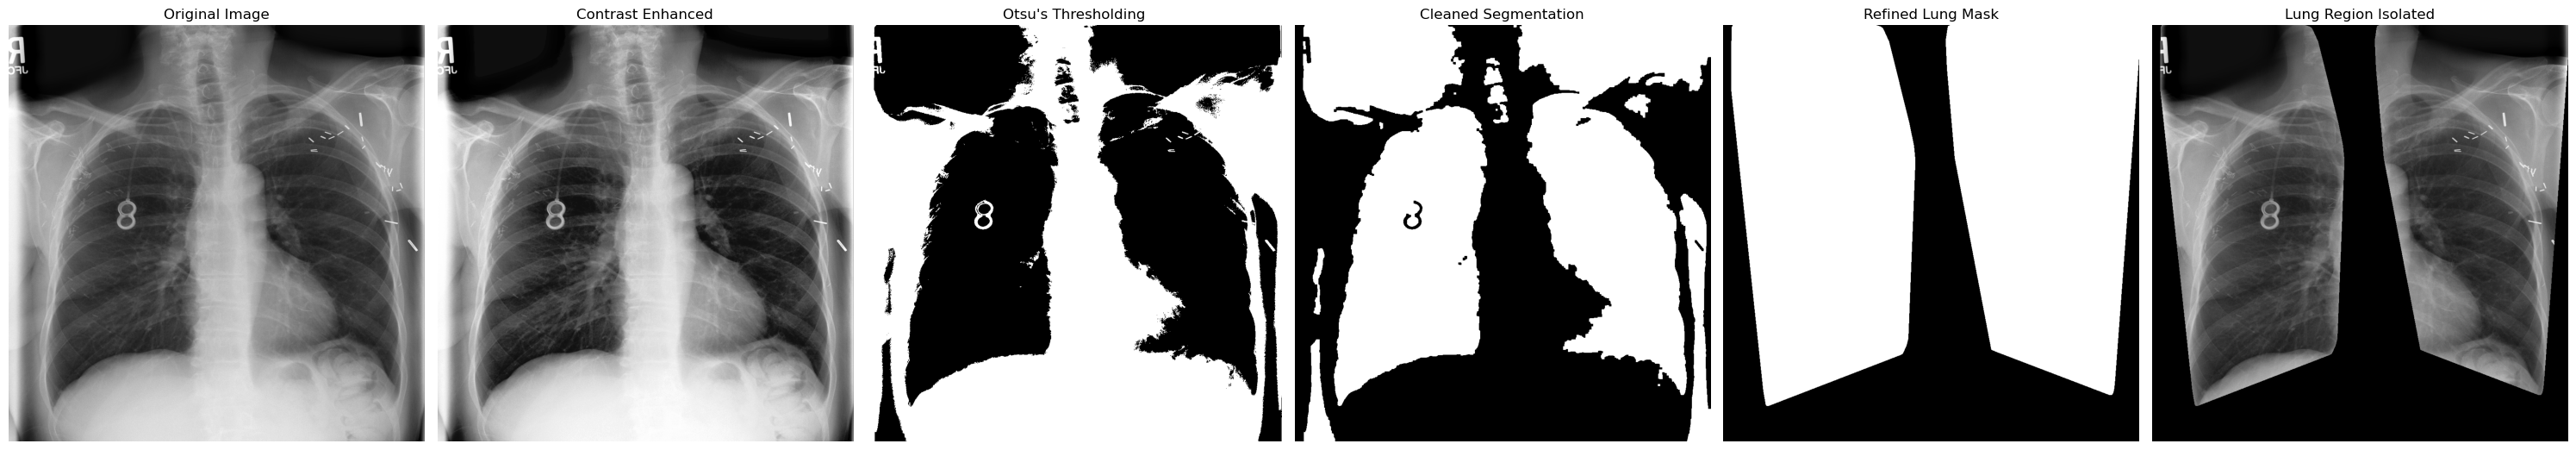

In [18]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def improved_lung_segmentation(image_path):
    # Step 1: Load the image
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    if image is None:
        raise ValueError(f"Cannot load image from {image_path}")

    # Step 2: Enhance contrast using histogram equalization
    enhanced_image = cv2.equalizeHist(image)

    # Step 3: Apply Otsu's thresholding
    _, otsu_thresh = cv2.threshold(enhanced_image, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    # Step 4: Complement the binary image for better visualization
    complemented_image = cv2.bitwise_not(otsu_thresh)

    # Step 5: Morphological operations to clean the segmentation
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (5, 5))
    cleaned_image = cv2.morphologyEx(complemented_image, cv2.MORPH_CLOSE, kernel)
    cleaned_image = cv2.morphologyEx(cleaned_image, cv2.MORPH_OPEN, kernel)

    # Step 6: Find connected components
    num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(cleaned_image)

    # Step 7: Select the two largest components (assumed to be lungs)
    sorted_indices = np.argsort(stats[1:, cv2.CC_STAT_AREA])[::-1] + 1
    lung_mask = np.zeros_like(cleaned_image, dtype=np.uint8)
    for i in sorted_indices[:2]:
        lung_mask[labels == i] = 255

    # Step 8: Refine lung mask using convex hull
    contours, _ = cv2.findContours(lung_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    hull_mask = np.zeros_like(lung_mask, dtype=np.uint8)
    for contour in contours:
        hull = cv2.convexHull(contour)
        cv2.drawContours(hull_mask, [hull], -1, 255, thickness=cv2.FILLED)

    # Step 9: Apply the refined mask to the original image
    lung_segmented = cv2.bitwise_and(image, image, mask=hull_mask)

    # Step 10: Display the results
    fig, axes = plt.subplots(1, 6, figsize=(30, 10))
    axes[0].imshow(image, cmap='gray')
    axes[0].set_title('Original Image')
    axes[0].axis('off')

    axes[1].imshow(enhanced_image, cmap='gray')
    axes[1].set_title('Contrast Enhanced')
    axes[1].axis('off')

    axes[2].imshow(otsu_thresh, cmap='gray')
    axes[2].set_title("Otsu's Thresholding")
    axes[2].axis('off')

    axes[3].imshow(cleaned_image, cmap='gray')
    axes[3].set_title('Cleaned Segmentation')
    axes[3].axis('off')

    axes[4].imshow(hull_mask, cmap='gray')
    axes[4].set_title('Refined Lung Mask')
    axes[4].axis('off')

    axes[5].imshow(lung_segmented, cmap='gray')
    axes[5].set_title('Lung Region Isolated')
    axes[5].axis('off')

    plt.tight_layout()
    plt.show()

# Example usage
image_path = 'chestX-ray8_dataset/00000072_000.png'
improved_lung_segmentation(image_path)

### Region growing algorithm
#### Manual thresholding selection

Selected 1779 seed points.
Selected 1779 seed points.
Selected 2772 seed points.


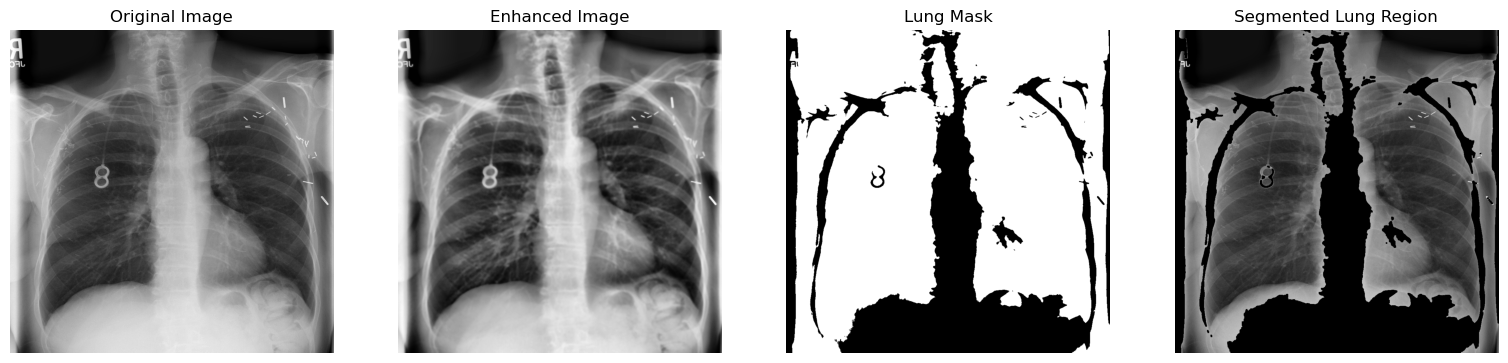

In [15]:
import cv2
import numpy as np
import tkinter as tk
from tkinter import filedialog, Scale, Label, Button, HORIZONTAL
from matplotlib.backends.backend_tkagg import FigureCanvasTkAgg
import matplotlib.pyplot as plt

class LungSegmentationApp:
    def __init__(self, root):
        self.root = root
        self.root.title("Lung Segmentation GUI")

        # Parameters
        self.image_path = None
        self.threshold = 100
        self.intensity_min = 0
        self.intensity_max = 100
        self.seeds = []

        # Layout
        Button(root, text="Load Image", command=self.load_image).pack(pady=10)

        Label(root, text="Threshold").pack()
        self.threshold_scale = Scale(root, from_=0, to=255, orient=HORIZONTAL, command=self.update_threshold)
        self.threshold_scale.set(self.threshold)
        self.threshold_scale.pack()

        Label(root, text="Intensity Min").pack()
        self.intensity_min_scale = Scale(root, from_=0, to=255, orient=HORIZONTAL, command=self.update_intensity_min)
        self.intensity_min_scale.set(self.intensity_min)
        self.intensity_min_scale.pack()

        Label(root, text="Intensity Max").pack()
        self.intensity_max_scale = Scale(root, from_=0, to=255, orient=HORIZONTAL, command=self.update_intensity_max)
        self.intensity_max_scale.set(self.intensity_max)
        self.intensity_max_scale.pack()

        Button(root, text="Run Segmentation", command=self.run_segmentation).pack(pady=10)

        # Canvas for displaying images
        self.figure, self.axes = plt.subplots(1, 4, figsize=(20, 5))
        self.canvas = FigureCanvasTkAgg(self.figure, master=root)
        self.canvas.get_tk_widget().pack()

    def load_image(self):
        self.image_path = filedialog.askopenfilename(filetypes=[("Image files", "*.png *.jpg *.jpeg *.bmp")])
        if self.image_path:
            self.display_image()

    def update_threshold(self, value):
        self.threshold = int(value)

    def update_intensity_min(self, value):
        self.intensity_min = int(value)

    def update_intensity_max(self, value):
        self.intensity_max = int(value)

    def display_image(self):
        if self.image_path:
            image = cv2.imread(self.image_path, cv2.IMREAD_GRAYSCALE)
            self.axes[0].imshow(image, cmap='gray')
            self.axes[0].set_title("Original Image")
            self.axes[0].axis('off')
            self.canvas.draw()

    def auto_select_seeds(self, image):
        rows, cols = image.shape
        margin = 50
        center_region = image[margin:rows - margin, margin:cols - margin]
        potential_seeds = np.argwhere(center_region < self.threshold)  # Find darker regions
        potential_seeds += margin  # Adjust for margin
        return [(x, y) for x, y in potential_seeds if margin < x < rows - margin and margin < y < cols - margin]

    def region_growing(self, image):
        rows, cols = image.shape
        segmented = np.zeros_like(image, dtype=np.uint8)  # Binary mask
        visited = np.zeros_like(image, dtype=bool)  # Visited pixels

        # Initialize the queue with seed points
        queue = self.seeds

        while queue:
            x, y = queue.pop(0)
            if visited[x, y]:
                continue

            visited[x, y] = True
            intensity = image[x, y]

            # Check if the pixel meets the intensity range criteria
            if self.intensity_min <= intensity <= self.intensity_max:
                segmented[x, y] = 255  # Include in segmentation

                # Add 8-connected neighbors
                for dx, dy in [(-1, 0), (1, 0), (0, -1), (0, 1), (-1, -1), (-1, 1), (1, -1), (1, 1)]:
                    nx, ny = x + dx, y + dy
                    if 0 <= nx < rows and 0 <= ny < cols and not visited[nx, ny]:
                        queue.append((nx, ny))

        return segmented

    def run_segmentation(self):
        if not self.image_path:
            print("Please load an image first.")
            return

        # Step 1: Load the X-ray image in grayscale
        image = cv2.imread(self.image_path, cv2.IMREAD_GRAYSCALE)

        # Step 2: Pre-process the image
        filtered_image = cv2.bilateralFilter(image, d=9, sigmaColor=75, sigmaSpace=75)
        clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
        enhanced_image = clahe.apply(filtered_image)

        # Step 3: Auto-select seeds
        self.seeds = self.auto_select_seeds(enhanced_image)
        print(f"Selected {len(self.seeds)} seed points.")

        # Step 4: Perform region growing
        segmented_mask = self.region_growing(enhanced_image)

        # Step 5: Refine segmentation mask
        kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (5, 5))
        refined_mask = cv2.morphologyEx(segmented_mask, cv2.MORPH_CLOSE, kernel)

        # Step 6: Apply mask to the original image
        lung_segmented = cv2.bitwise_and(image, image, mask=refined_mask)

        # Step 7: Update GUI with results
        self.axes[0].imshow(image, cmap='gray')
        self.axes[0].set_title('Original Image')
        self.axes[0].axis('off')

        self.axes[1].imshow(enhanced_image, cmap='gray')
        self.axes[1].set_title('Enhanced Image')
        self.axes[1].axis('off')

        self.axes[2].imshow(segmented_mask, cmap='gray')
        self.axes[2].set_title('Lung Mask')
        self.axes[2].axis('off')

        self.axes[3].imshow(lung_segmented, cmap='gray')
        self.axes[3].set_title('Segmented Lung Region')
        self.axes[3].axis('off')

        self.canvas.draw()


# Run the GUI application
root = tk.Tk()
app = LungSegmentationApp(root)
root.mainloop()


## Starting Point Selection
#### User seeding point selection

Auto-initialized threshold: 200
Seed point added: (315, 606)
Auto-initialized threshold: 200
Seed point added: (371, 599)
Auto-initialized threshold: 200


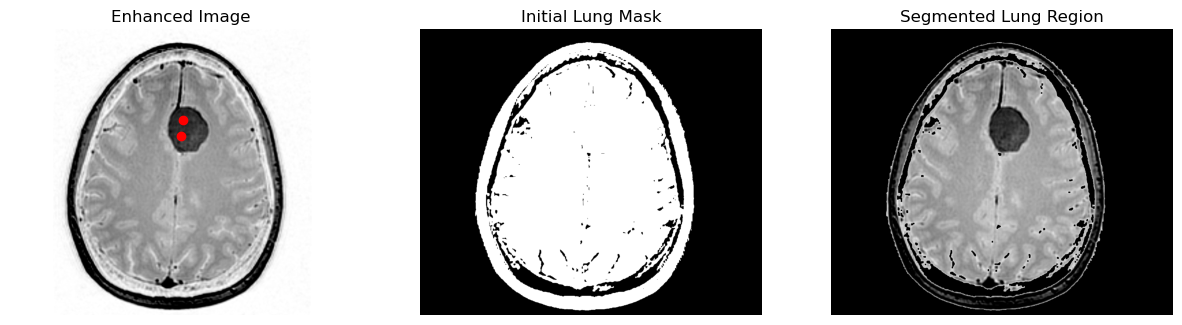

In [19]:
import cv2
import numpy as np
import tkinter as tk
from tkinter import filedialog, Scale, Label, Button, HORIZONTAL
from matplotlib.backends.backend_tkagg import FigureCanvasTkAgg
import matplotlib.pyplot as plt

class LungSegmentationApp:
    def __init__(self, root):
        self.root = root
        self.root.title("Lung Segmentation GUI")

        # Parameters
        self.image_path = None
        self.threshold = 100
        self.seeds = []
        self.image = None  # Loaded image

        # Layout
        Button(root, text="Load Image", command=self.load_image).pack(pady=10)

        Label(root, text="Threshold").pack()
        self.threshold_scale = Scale(root, from_=0, to=255, orient=HORIZONTAL, command=self.update_threshold)
        self.threshold_scale.set(self.threshold)
        self.threshold_scale.pack()

        Button(root, text="Run Segmentation", command=self.run_segmentation).pack(pady=10)

        # Canvas for displaying images
        self.figure, self.axes = plt.subplots(1, 3, figsize=(15, 5))
        self.canvas = FigureCanvasTkAgg(self.figure, master=root)
        self.canvas.get_tk_widget().pack()

        # Event binding for clicking on the image
        self.canvas.mpl_connect('button_press_event', self.on_image_click)

    def load_image(self):
        """Allow the user to load an enhanced image."""
        self.image_path = filedialog.askopenfilename(filetypes=[("Image files", "*.png *.jpg *.jpeg *.bmp")])
        if self.image_path:
            self.image = cv2.imread(self.image_path, cv2.IMREAD_GRAYSCALE)
            self.seeds = []  # Reset seeds
            self.auto_initialize_threshold()
            self.display_image()

    def auto_initialize_threshold(self):
        """Automatically set the initial threshold based on image statistics."""
        if self.image is not None:
            self.threshold = int(np.mean(self.image))  # Use mean intensity
            self.threshold_scale.set(self.threshold)
            print(f"Auto-initialized threshold: {self.threshold}")

    def update_threshold(self, value):
        """Update the threshold value."""
        self.threshold = int(value)

    def display_image(self):
        """Display the loaded enhanced image."""
        if self.image is not None:
            self.axes[0].cla()
            self.axes[0].imshow(self.image, cmap='gray')
            self.axes[0].set_title("Enhanced Image (Click to Select Seed)")
            self.axes[0].axis('off')
            self.canvas.draw()

    def on_image_click(self, event):
        """Capture user clicks on the image to select seed points."""
        if self.image is not None and event.inaxes == self.axes[0]:
            x, y = int(event.ydata), int(event.xdata)  # Convert click coordinates
            self.seeds.append((x, y))
            print(f"Seed point added: ({x}, {y})")

            # Mark the seed point on the image
            self.axes[0].plot(y, x, 'ro')  # Red dot for seed point
            self.canvas.draw()

    def region_growing(self, image):
        """Perform region growing based on manually selected seed points."""
        rows, cols = image.shape
        segmented = np.zeros_like(image, dtype=np.uint8)  # Binary mask
        visited = np.zeros_like(image, dtype=bool)  # Visited pixels

        # Initialize the queue with manually selected seed points
        queue = list(self.seeds)

        while queue:
            x, y = queue.pop(0)
            if visited[x, y]:
                continue

            visited[x, y] = True
            intensity = image[x, y]

            # Check if the pixel meets the threshold criteria
            if intensity < self.threshold:
                segmented[x, y] = 255  # Include in segmentation

                # Add 8-connected neighbors
                for dx, dy in [(-1, 0), (1, 0), (0, -1), (0, 1), (-1, -1), (-1, 1), (1, -1), (1, 1)]:
                    nx, ny = x + dx, y + dy
                    if 0 <= nx < rows and 0 <= ny < cols and not visited[nx, ny]:
                        queue.append((nx, ny))

        return segmented

    def run_segmentation(self):
        """Perform segmentation using region growing and refine the mask."""
        if self.image is None or not self.seeds:
            print("Please load an image and select seed points first.")
            return

        # Step 1: Automatically initialize threshold if needed
        self.auto_initialize_threshold()

        # Step 2: Perform region growing
        segmented_mask = self.region_growing(self.image)

        # Step 3: Refine segmentation mask
        kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (5, 5))
        refined_mask = cv2.morphologyEx(segmented_mask, cv2.MORPH_CLOSE, kernel)

        # Step 4: Apply mask to the original image
        lung_segmented = cv2.bitwise_and(self.image, self.image, mask=refined_mask)

        # Step 5: Update GUI with results
        self.axes[0].imshow(self.image, cmap='gray')
        self.axes[0].set_title('Enhanced Image')
        self.axes[0].axis('off')

        self.axes[1].imshow(segmented_mask, cmap='gray')
        self.axes[1].set_title('Initial Lung Mask')
        self.axes[1].axis('off')

        self.axes[2].imshow(lung_segmented, cmap='gray')
        self.axes[2].set_title('Segmented Lung Region')
        self.axes[2].axis('off')

        self.canvas.draw()

# Run the GUI application
root = tk.Tk()
app = LungSegmentationApp(root)
root.mainloop()


## Snake Algorithm

Iteration 0/100


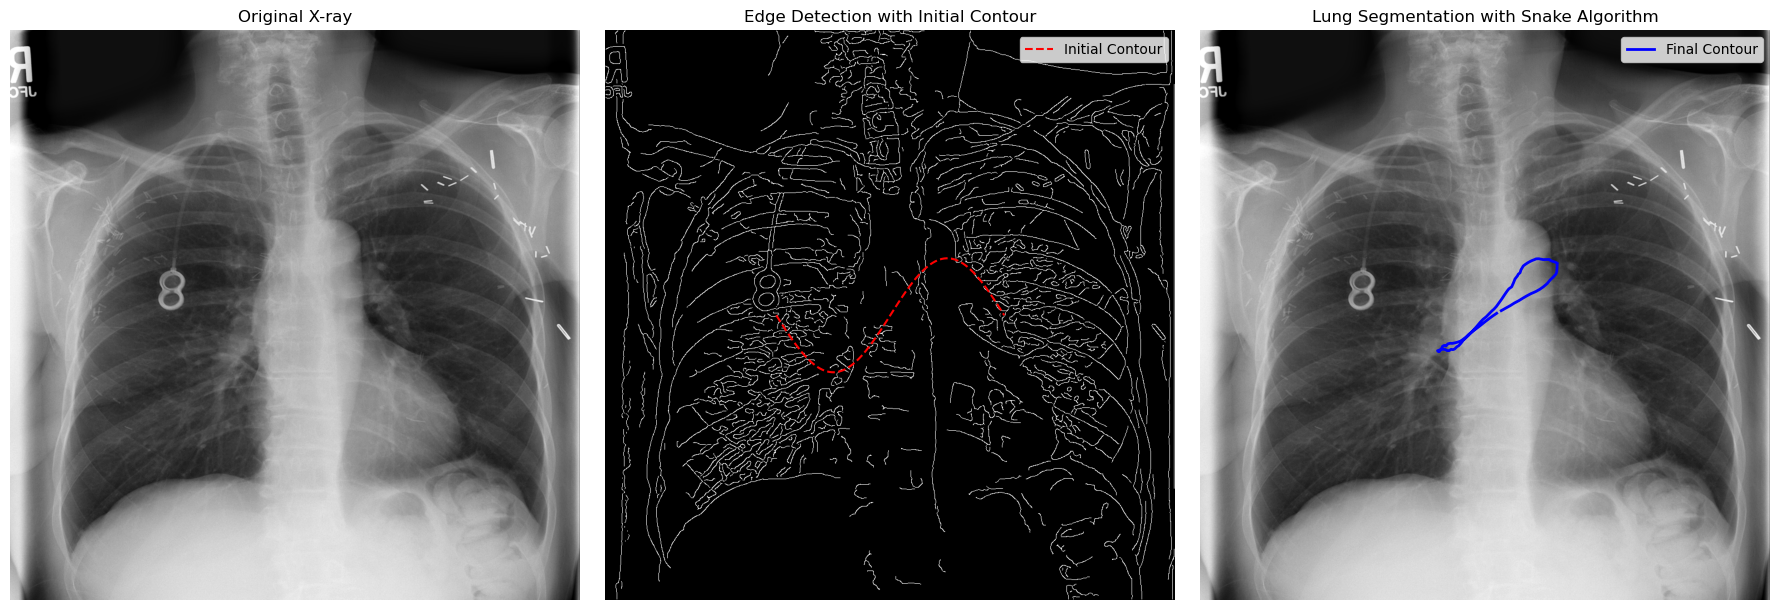

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from skimage import io, color, filters, exposure
from skimage.segmentation import active_contour
from skimage.feature import canny

# Load the X-ray image
image_path = 'chestX-ray8_dataset/00000072_000.png'
xray_image = io.imread(image_path)
xray_image_gray = color.rgb2gray(xray_image) if len(xray_image.shape) == 3 else xray_image

# Enhance contrast
xray_image_enhanced = exposure.equalize_adapthist(xray_image_gray, clip_limit=0.03)

# Apply Gaussian smoothing
xray_image_smooth = filters.gaussian(xray_image_enhanced, sigma=1)

# Perform edge detection (Canny)
edges = canny(xray_image_smooth, sigma=2)

# Initialize a circular contour near the lungs
rows, cols = xray_image_smooth.shape
# Adjust the initial placement of the contour
init_x = np.linspace(cols * 0.3, cols * 0.7, 100)
init_y = rows * 0.5 + (rows * 0.1 * np.sin(np.linspace(0, 2 * np.pi, 100)))
init_contour = np.array([init_x, init_y]).T

contour = init_contour.copy()
num_iterations = 100
for i in range(num_iterations):
    contour = active_contour(
        edges,               # Edge-detected image
        contour,             # Updated contour
        alpha=0.05,          # Snake elasticity (smoothness)
        beta=1.0,            # Snake rigidity (bending resistance)
        gamma=0.01,          # Step size
        convergence=0.001    # Tighter convergence
    )
    if i % 500 == 0: 
        print(f"Iteration {i}/{num_iterations}")

fig, ax = plt.subplots(1, 3, figsize=(18, 6))
ax[0].imshow(xray_image_gray, cmap='gray')
ax[0].set_title("Original X-ray")
ax[0].axis('off')

ax[1].imshow(edges, cmap='gray')
ax[1].plot(init_contour[:, 0], init_contour[:, 1], '--r', label='Initial Contour')
ax[1].set_title("Edge Detection with Initial Contour")
ax[1].legend()
ax[1].axis('off')

ax[2].imshow(xray_image_gray, cmap='gray')
ax[2].plot(contour[:, 0], contour[:, 1], '-b', lw=2, label='Final Contour')
ax[2].set_title("Lung Segmentation with Snake Algorithm")
ax[2].legend()
ax[2].axis('off')

plt.tight_layout()
plt.show()